In [54]:
# General support
import math
import tensorflow as tf
import numpy as np

# For plots
import matplotlib.pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE

# General lucid code
from lucid.misc.io import save, show, load
import lucid.modelzoo.vision_models as models

# For rendering feature visualizations
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

In [55]:
model = models.InceptionV1()
model.load_graphdef()

In [57]:


# 获取模型的图
graph = model.graph

# 打印每个操作节点的名称和类型
for op in graph.get_operations():
    print(op.name, op.type)

AttributeError: 'InceptionV1' object has no attribute 'graph'

In [29]:
model.summary()

AttributeError: 'InceptionV1' object has no attribute 'summary'

In [3]:
# 导入模块
import os
# 设置代理。这里 1080 既可以是 http 代理的端口，也可以是 socks5 代理的端口
proxy = 'http://127.0.0.1:16888'
os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [27]:
from joblib import dump, load

# model.layers[7] is "mixed4c"
layer = "mixed4c"
print(model.layers[7])
raw_activations = model.layers[7].activations
raw_activations = load('datas/raw_activations.joblib')
activations = raw_activations[:100000]
print(activations.shape)

Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}])
(100000, 512)


In [28]:
activations

array([[  0.      , 113.36031 ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,  13.167304, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [ 57.95606 ,   0.      ,  17.873251, ..., 190.47272 ,   0.      ,
          0.      ],
       [  0.      ,  89.09428 ,   0.      , ...,   0.      ,  14.217269,
          0.      ],
       [  0.      , 115.30253 ,  10.15035 , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

In [26]:
model.layers

(Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
 Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
 Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
 Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
 Layer (belonging to InceptionV1) <head1_bottl

In [9]:
# from joblib import dump, load
# from lucid.misc.io import load

# 保存 raw_activations 到本地文件
# dump(raw_activations, 'datas/raw_activations.joblib')

数据白化

In [8]:
def whiten(full_activations):
    correl = np.matmul(full_activations.T, full_activations) / len(full_activations)
    correl = correl.astype("float32")
    S = np.linalg.inv(correl)
    S = S.astype("float32")
    return S

In [12]:
S = whiten(raw_activations)
S.shape

In [13]:
S.shape

(512, 512)

In [16]:
# 归一化处理 
def normalize_layout(layout, min_percentile=1, max_percentile=99, relative_margin=0.1):
    """Removes outliers and scales layout to between [0,1]."""

    # compute percentiles
    mins = np.percentile(layout, min_percentile, axis=(0))
    maxs = np.percentile(layout, max_percentile, axis=(0))

    # add margins
    mins -= relative_margin * (maxs - mins)
    maxs += relative_margin * (maxs - mins)

    # `clip` broadcasts, `[None]`s added only for readability
    clipped = np.clip(layout, mins, maxs)

    # embed within [0,1] along both axes
    clipped -= clipped.min(axis=0)
    clipped /= clipped.max(axis=0)

    return clipped

In [17]:
layout = umap.UMAP(n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(activations)

## You can optionally use TSNE as well
# layout = TSNE(n_components=2, verbose=True, metric="cosine", learning_rate=10, perplexity=50).fit_transform(d)

layout = normalize_layout(layout)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Tue Mar  5 15:08:26 2024 Construct fuzzy simplicial set
Tue Mar  5 15:08:26 2024 Finding Nearest Neighbors
Tue Mar  5 15:08:26 2024 Building RP forest with 21 trees
Tue Mar  5 15:08:27 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Tue Mar  5 15:08:30 2024 Finished Nearest Neighbor Search
Tue Mar  5 15:08:30 2024 Construct embedding


Epochs completed:   2%| ▏          4/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:03]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [00:06]

	completed  40  /  200 epochs


Epochs completed:  31%| ███        62/200 [00:08]

	completed  60  /  200 epochs


Epochs completed:  41%| ████       82/200 [00:11]

	completed  80  /  200 epochs


Epochs completed:  51%| █████      102/200 [00:14]

	completed  100  /  200 epochs


Epochs completed:  61%| ██████     122/200 [00:17]

	completed  120  /  200 epochs


Epochs completed:  71%| ███████    142/200 [00:20]

	completed  140  /  200 epochs


Epochs completed:  81%| ████████   162/200 [00:22]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [00:25]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:28]


Tue Mar  5 15:09:04 2024 Finished embedding


In [19]:
layout.shape

(100000, 2)

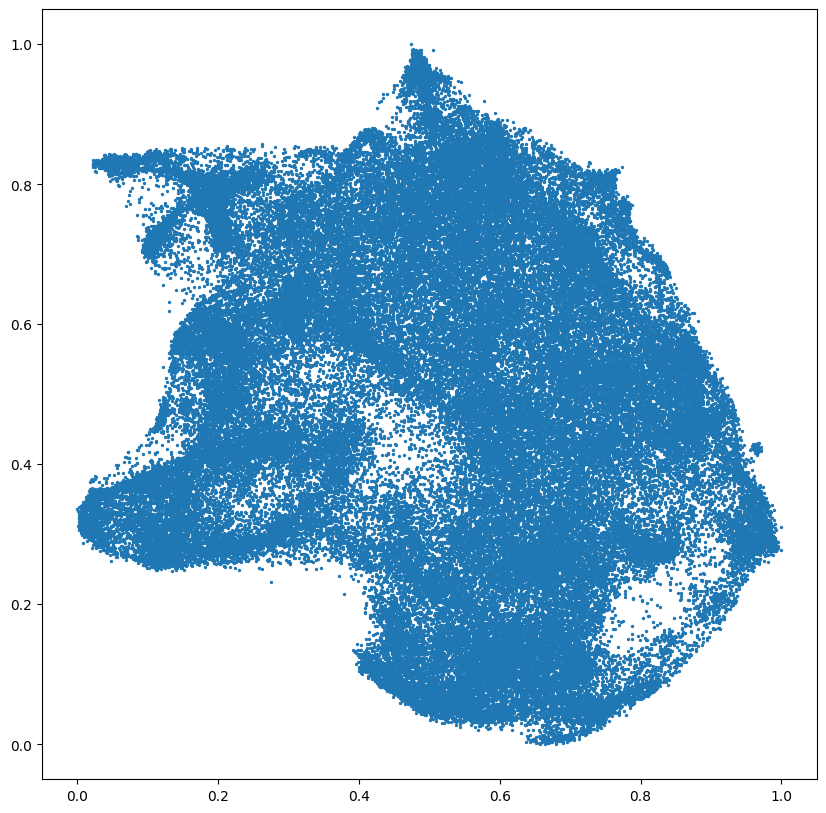

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(x=layout[:,0],y=layout[:,1], s=2)
plt.show()

In [9]:
model.get_layer(layer)

Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}])

In [ ]:
getattr(model, layer_name)

### Feature visualization

In [21]:
# 
# Whitened, euclidean neuron objective
# 
@objectives.wrap_objective
def direction_neuron_S(layer_name, vec, batch=None, x=None, y=None, S=None):
    def inner(T):
        layer = T(layer_name)
        shape = tf.shape(layer)
        x_ = shape[1] // 2 if x is None else x
        y_ = shape[2] // 2 if y is None else y
        if batch is None:
            raise RuntimeError("requires batch")

        acts = layer[batch, x_, y_]
        vec_ = vec
        if S is not None: vec_ = tf.matmul(vec_[None], S)[0]
        # mag = tf.sqrt(tf.reduce_sum(acts**2))
        dot = tf.reduce_mean(acts * vec_)
        # cossim = dot/(1e-4 + mag)
        return dot
    return inner

# 
# Whitened, cosine similarity objective
# 
@objectives.wrap_objective
def direction_neuron_cossim_S(layer_name, vec, batch=None, x=None, y=None, cossim_pow=1, S=None):
    def inner(T):
        layer = model.get_layer(layer_name)
        shape = tf.shape(layer)
        x_ = shape[1] // 2 if x is None else x
        y_ = shape[2] // 2 if y is None else y
        if batch is None:
          raise RuntimeError("requires batch")

        acts = layer[batch, x_, y_]
        vec_ = vec
        if S is not None: vec_ = tf.matmul(vec_[None], S)[0]
        mag = tf.sqrt(tf.reduce_sum(acts**2))
        dot = tf.reduce_mean(acts * vec_)
        cossim = dot/(1e-4 + mag)
        cossim = tf.maximum(0.1, cossim)
        return dot * cossim ** cossim_pow
    return inner

#
# Renders a batch of activations as icons
#
def render_icons(directions, model, layer, size=80, n_steps=128, verbose=False, S=None, num_attempts=2, cossim=True, alpha=True):
    image_attempts = []
    loss_attempts = []

    # Render multiple attempts, and pull the one with the lowest loss score.
    for attempt in range(num_attempts):

      # Render an image for each activation vector
      param_f = lambda: param.image(size, batch=directions.shape[0], fft=True, decorrelate=True, alpha=alpha)
      if(S is not None):
          if(cossim is True):
              obj_list = ([
                direction_neuron_cossim_S(layer, v, batch=n, S=S, cossim_pow=4) for n,v in enumerate(directions)
              ]) 
          else: 
              obj_list = ([
                direction_neuron_S(layer, v, batch=n, S=S) for n,v in enumerate(directions)
              ])    
      else: 
          obj_list = ([
            objectives.direction_neuron(layer, v, batch=n) for n,v in enumerate(directions)
          ])

      obj = objectives.Objective.sum(obj_list)

      transforms = []
      if alpha:
          transforms.append(transform.collapse_alpha_random())
      transforms.append(transform.pad(2, mode='constant', constant_value=1))
      transforms.append(transform.jitter(4))
      transforms.append(transform.jitter(4))
      transforms.append(transform.jitter(8))
      transforms.append(transform.jitter(8))
      transforms.append(transform.jitter(8))
      transforms.append(transform.random_scale([0.995**n for n in range(-5,80)] + [0.998**n for n in 2*list(range(20,40))]))
      transforms.append(transform.random_rotate(list(range(-20,20))+list(range(-10,10))+list(range(-5,5))+5*[0]))
      transforms.append(transform.jitter(2))

      # This is the tensorflow optimization process.
      # We can't use the lucid helpers here because we need to know the loss.

      print("attempt: ", attempt)
      with tf.Graph().as_default(), tf.Session() as sess:
          learning_rate = 0.05
          losses = []
          trainer = tf.train.AdamOptimizer(learning_rate)
          T = render.make_vis_T(model, obj, param_f, trainer, transforms)
          loss_t, vis_op, t_image = T("loss"), T("vis_op"), T("input")
          losses_ = [obj_part(T) for obj_part in obj_list]
          tf.global_variables_initializer().run()
          for i in range(n_steps):
              loss, _ = sess.run([losses_, vis_op])
              losses.append(loss)
              if (i % 100 == 0):
                  print(i)

          img = t_image.eval()
          img_rgb = img[:,:,:,:3]
          if alpha:
              print("alpha true")
              k = 0.8
              bg_color = 0.0
              img_a = img[:,:,:,3:]
              img_merged = img_rgb*((1-k)+k*img_a) + bg_color * k*(1-img_a)
              image_attempts.append(img_merged)
          else:
              print("alpha false")
              image_attempts.append(img_rgb)

          loss_attempts.append(losses[-1])

    # Use the icon with the lowest loss
    loss_attempts = np.asarray(loss_attempts)   
    loss_final = []
    image_final = []
    print("Merging best scores from attempts...")
    for i, d in enumerate(directions):
        # note, this should be max, it is not a traditional loss
        mi = np.argmax(loss_attempts[:,i])
        image_final.append(image_attempts[mi][i])

    return (image_final, loss_final)
  
  


### Grid

In [34]:
# 
# Takes a list of x,y layout and bins them into grid cells
# 
def grid(xpts=None, ypts=None, grid_size=(8,8), x_extent=(0., 1.), y_extent=(0., 1.)):
    xpx_length = grid_size[0]
    ypx_length = grid_size[1]

    xpt_extent = x_extent
    ypt_extent = y_extent

    xpt_length = xpt_extent[1] - xpt_extent[0]
    ypt_length = ypt_extent[1] - ypt_extent[0]

    xpxs = ((xpts - xpt_extent[0]) / xpt_length) * xpx_length
    ypxs = ((ypts - ypt_extent[0]) / ypt_length) * ypx_length

    ix_s = range(grid_size[0])
    iy_s = range(grid_size[1])
    xs = []
    for xi in ix_s:
        ys = []
        for yi in iy_s:
            xpx_extent = (xi, (xi + 1))
            ypx_extent = (yi, (yi + 1))

            in_bounds_x = np.logical_and(xpx_extent[0] <= xpxs, xpxs <= xpx_extent[1])
            in_bounds_y = np.logical_and(ypx_extent[0] <= ypxs, ypxs <= ypx_extent[1])
            in_bounds = np.logical_and(in_bounds_x, in_bounds_y)

            in_bounds_indices = np.where(in_bounds)[0]
            ys.append(in_bounds_indices)
        xs.append(ys)
    return np.asarray(xs)


In [36]:
def render_layout(model, layer, S, xs, ys, activ, n_steps=512, n_attempts=2, min_density=10, grid_size=(10, 10), icon_size=80, x_extent=(0., 1.0), y_extent=(0., 1.0)):
    grid_layout = grid(xpts=xs, ypts=ys, grid_size=grid_size, x_extent=x_extent, y_extent=y_extent)
    icons = []

    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            indices = grid_layout[x, y]
            if len(indices) > min_density:
                average_activation = np.average(activ[indices], axis=0)
                icons.append((average_activation, x, y))

    icons = np.asarray(icons)
    icon_batch, losses = render_icons(icons[:,0], model, alpha=False, layer=layer, S=S, n_steps=n_steps, size=icon_size, num_attempts=n_attempts)

    canvas = np.ones((icon_size * grid_size[0], icon_size * grid_size[1], 3))
    for i, icon in enumerate(icon_batch):
        y = int(icons[i, 1])
        x = int(icons[i, 2])
        canvas[(grid_size[0] - x - 1) * icon_size:(grid_size[0] - x) * icon_size, (y) * icon_size:(y + 1) * icon_size] = icon

    return canvas


In [24]:
model.layers

(Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
 Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
 Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
 Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
 Layer (belonging to InceptionV1) <head1_bottl

In [40]:
ys

array([0.26799749, 0.46322571, 0.70534844, ..., 0.78895112, 0.28596577,
       0.23056272])

In [42]:
tmp = grid(xs, ys, grid_size=(8,8), x_extent=(0., 1.), y_extent=(0., 1.))

/home/vkeilo/miniconda3/envs/Atlas/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [53]:
tmp[0][3]

array([  478,   585,   711,   750,   804,  1120,  1277,  1552,  1726,
        1762,  1780,  1817,  1997,  2209,  2228,  2290,  2358,  2470,
        2674,  3234,  3818,  3940,  4027,  4037,  4432,  4512,  4668,
        4876,  4923,  5273,  5514,  6268,  6682,  7065,  7371,  7414,
        7511,  7547,  7586,  7601,  7851,  7939,  8005,  8340,  8410,
        8540,  8902,  9061,  9080,  9106, 10016, 10124, 10402, 10875,
       10955, 11055, 11273, 11320, 12178, 12754, 12999, 13233, 13273,
       13353, 13600, 14306, 14347, 14672, 14699, 14863, 14946, 15485,
       15705, 16315, 16320, 16350, 16687, 17130, 17701, 17931, 18058,
       18383, 19402, 19410, 19535, 19628, 19654, 19814, 19857, 19864,
       20027, 20116, 20172, 20591, 20694, 20696, 20932, 21043, 21283,
       21338, 21357, 21527, 21691, 21852, 21882, 21963, 22332, 22875,
       23445, 24230, 24325, 24522, 24944, 25168, 25317, 25341, 25492,
       25611, 25704, 25974, 26051, 26123, 26287, 26557, 26757, 27437,
       27479, 27565,

In [37]:
# 
# Given a layout, renders an icon for the average of all the activations in each grid cell.
# 

xs = layout[:, 0]
ys = layout[:, 1]
canvas = render_layout(model, layer, S, xs, ys, raw_activations, n_steps=512, grid_size=(20, 20), n_attempts=1)
show(canvas)


0


In [22]:
# 创建T对象
TT = param.image(128)

# 获取模型中的某一层的张量
layer = TT("mixed4a")

TypeError: 'Tensor' object is not callable

In [11]:
@objectives.wrap_objective
def ttt():
    
    return 0

In [25]:
model('mixed4c') 

TypeError: 'InceptionV1' object is not callable